# MCMC

这个notebook呈现我们怎么样通过使用MCMC来生成图片动画。

In [2]:
import imcmc
import numpy as np
from IPython.display import Image

# 不同的抽样函数

In [3]:
class FakeTrace:
    """Pymc3中用来生成抽样样本的轨迹类"""
    
    def __init__(self, trace):
        self.chains = list(range(len(trace)))
        self.trace = trace

    def get_values(self, *args, chains=None, **kwargs):
        return self.trace[chains]

def rejection_sampling(image, samples):
    """拒绝采样方法 """
    
    image_pdf = image / image.sum()
    pdf_max = image_pdf.max()
    height, width = image_pdf.shape
    p_success = 1 / (height * width * pdf_max)
    actual_samples = min(int(samples / p_success), int(1e8))
    samples_height = np.random.randint(0, high=height, size=actual_samples)
    samples_width = np.random.randint(0, high=width, size=actual_samples)
    samples_uniform = np.random.uniform(0, 1, size=actual_samples)

    good_samples = [(h, w) for (h, w, u) in zip(samples_height, samples_width, samples_uniform) if
                    (image_pdf[h, w] >= pdf_max * u)]
    
    return FakeTrace([np.array(good_samples)])


def gibbs_sampling_single(image, w_start, samples):
    """吉布斯采样"""
    
    image_pdf = image / image.sum()
    height, width = image_pdf.shape
    samples_list = []
    w_current = w_start
    
    for _ in range(samples):
        # 为图片的高度采样
        h_given_w = image_pdf[:, w_current] / image_pdf[:, w_current].sum()
        h_current = np.random.choice(np.array(range(height)), size=1, p=h_given_w)[0]

        # 为图片的宽度采样
        w_given_h = image_pdf[h_current, :] / image_pdf[h_current, :].sum()
        w_current = np.random.choice(np.array(range(width)), size=1, p=w_given_h)[0]

        samples_list.append((h_current, w_current))

    return np.array(samples_list)

def gibbs_sampling(image, samples, nchains, threshold=0.8):
    """Gibbs多链采样"""
    
    image_copy = image.copy()
    if threshold is not None:
        # 对于阈值下的值不予理睬
        image_copy[image < threshold] = 0
        image_copy[image >= threshold] = 1
    
    active_pixels = np.array(list(zip(*np.where(image_copy == image_copy.max()))))
    idx = np.random.randint(0, len(active_pixels), nchains)
    start = active_pixels[idx]

    return FakeTrace([gibbs_sampling_single(image_copy, w_start=start_point[1], samples=samples)
            for start_point in start])

In [4]:
def main(input_path,
         output_path,
         nchains,
         samples,
         marker,
         markersize,
         leading_point,
         interval,
         colors,
         approach,
         threshold):
    """Main wrapping function."""
    
    image = imcmc.load_image(input_path, 'L')

    if approach == 'rs':
        trace = rejection_sampling(image, samples=samples)
    elif approach == 'gibbs':
        trace = gibbs_sampling(image, samples=samples, nchains=nchains, threshold=threshold)
    elif approach == 'default':
        trace = imcmc.sample_grayscale(image, samples=samples, nchains=nchains, threshold=threshold)
    else:
        raise ValueError('Unrecognized approach')

    imcmc.make_gif(trace, image,
                   dpi=30,
                   marker=marker,
                   markersize=markersize,
                   colors=colors,
                   alpha=0.9,
                   leading_point=leading_point,
                   interval=interval,
                   filename=output_path)

# Parameters

In [53]:
input_path = './libs/logomakr-3sxxzw-192x192.png'
output_path = './libs/new.gif'

approach = 'gibbs'  # sampling method, 'default'=pymc3 metropolis, 'rs'=rejection sampling, 'gibbs'=gibbs sampling
threshold = 0.5  # image preprocessing, turns light gray into white and dark gray into black -> better initialization
nchains = 1
samples = 10000
marker = '*'
markersize = 4
leading_point =  True  # bool, if True current sampled point has a bigger marker
interval = 30
colors = ['#010101', '#FF0000', '#FFFF00', '#00FF00']

# Main

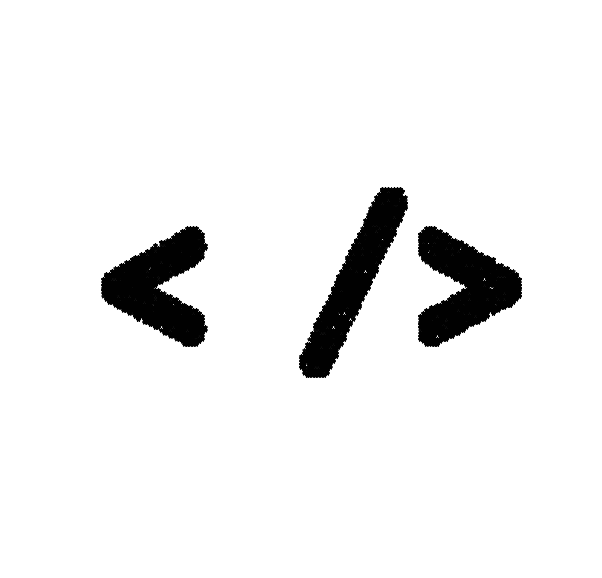

In [54]:
main(input_path=input_path,
             output_path=output_path,
             nchains=nchains,
             samples=samples,
             marker=marker,
             markersize=markersize,
             leading_point=leading_point,
             interval=interval,
             colors=colors,
             approach=approach,
             threshold=threshold)

# View result

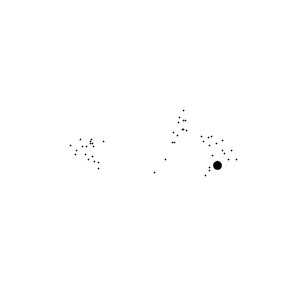

In [55]:
Image(filename=output_path)